# How-to: Using SSB API data

[Statistics Norway (Statistisk sentralbryå, SSB)](https://www.ssb.no) is an excellent source of data on Norway and the Norwegian population. Their [ready-made API data sets](https://data.ssb.no/api/?lang=en) are particularly convenient for accessing data on certain topics. But working with the data can still have some challenges. 

This How-to works through downloading, importing and working with ready-made datasets using Python and Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

Let us start by downloading a simple dataset of population of each municipality (kommune) over many years. We can use the direct link to the csv dataset.

Notice that I specify *encoding = "ISO-8859-1"*. This is because otherwise python has difficulty interpreting the special Norwegian characters (Ø,Æ,Å).

In [3]:
pop = pd.read_csv("https://data.ssb.no/api/v0/dataset/26975.csv?lang=en", encoding = "ISO-8859-1")


The above data set is from the english-language version of the open API dataset. If you import the data from the norwegian language dataset you need a slight change in the command: 

In [5]:
pop = pd.read_csv("https://data.ssb.no/api/v0/dataset/26975.csv?lang=no", 
                  encoding = "ISO-8859-1", sep=";", decimal=",")


The difference is because in the Norwegian-language data, a decimal is represented as a "," rather than a ".". So we would write 5,8 for example, rather than 5.8. 

That also means that unlike in the english-language data, where a *,* is used to seperate the columns, the norwegian data uses ";" to seperate columns. 

You can put the above URL's to see the raw data. 

We can take a look at the dataset and the columns

In [4]:
pop

,region,year,contents,"07459: Population, by region, year and contents"
0,K-3001 Halden,1986,Persons,25844
1,K-3001 Halden,1987,Persons,25807
2,K-3001 Halden,1988,Persons,25848
3,K-3001 Halden,1989,Persons,25841
4,K-3001 Halden,1990,Persons,25816
...,...,...,...,...
13278,K-Rest Divided municalities and unknown,2018,Persons,53892
13279,K-Rest Divided municalities and unknown,2019,Persons,53951
13280,K-Rest Divided municalities and unknown,2020,Persons,0
13281,K-Rest Divided municalities and unknown,2021,Persons,0


We notice that the *region* variable includes a combination of the municipality number and the name of the municipality. 

We can use the string (text) functions that are integrated in pandas in order to extract the municipality number (kommunenummer) and put it in a seperate columns. In particular we will use the *slice()* function which extracts a portion of a text object from a start point upto (but not including) an end point. 

In [5]:
pop["kommunenummer"] = pop.region.str.slice(start=2, stop=6)
pop

,region,year,contents,"07459: Population, by region, year and contents",kommunenummer
0,K-3001 Halden,1986,Persons,25844,3001
1,K-3001 Halden,1987,Persons,25807,3001
2,K-3001 Halden,1988,Persons,25848,3001
3,K-3001 Halden,1989,Persons,25841,3001
4,K-3001 Halden,1990,Persons,25816,3001
...,...,...,...,...,...
13278,K-Rest Divided municalities and unknown,2018,Persons,53892,Rest
13279,K-Rest Divided municalities and unknown,2019,Persons,53951,Rest
13280,K-Rest Divided municalities and unknown,2020,Persons,0,Rest
13281,K-Rest Divided municalities and unknown,2021,Persons,0,Rest


We get some extra entries at the bottom which we would like to exclude: 

In [6]:
pop = pop.loc[pop.kommunenummer!="Rest",:]
pop = pop.loc[pop.kommunenummer!="23 K",:]
pop = pop.loc[pop.kommunenummer!="21-2",:]
pop = pop.loc[pop.kommunenummer!="23 C",:]

If we are downloading several similar datasets, and we wish to repeat the steps above, we could put the above within a function:

In [7]:
def cleanRegion(df, start, stop): 
        # takes the "region" column
        #then the municipality number (kommunenummer) then the name of the municipality "kommunenavn"
        #Here we can extract the number from this string using the slice function, 
        #extracting the string from position 2 upto 6
        
        df["kommunenummer"] = df.region.str.slice(start=start, stop=stop)
        df = df.loc[df.kommunenummer!="Rest",:]
        df = df.loc[df.kommunenummer!="23 K",:]
        df = df.loc[df.kommunenummer!="21-2",:]
        df = df.loc[df.kommunenummer!="23 C",:]
        return(df)

Then we could simply do this: 

In [8]:

pop = cleanRegion(pop, 2, 6)

Let's take a look at the variables in our dataset: 

In [9]:
pop.columns


Index(['region', 'year', 'contents',
       '07459: Population, by region, year and contents', 'kommunenummer'],
      dtype='object')

Let's change simplify the variable name for the population variable:

In [10]:
pop = pop.rename(columns = {'07459: Population, by region, year and contents':"population"})

In [11]:
pop

,region,year,contents,population,kommunenummer
0,K-3001 Halden,1986,Persons,25844,3001
1,K-3001 Halden,1987,Persons,25807,3001
2,K-3001 Halden,1988,Persons,25848,3001
3,K-3001 Halden,1989,Persons,25841,3001
4,K-3001 Halden,1990,Persons,25816,3001
...,...,...,...,...,...
13167,K-5444 Sør-Varanger,2018,Persons,10171,5444
13168,K-5444 Sør-Varanger,2019,Persons,10156,5444
13169,K-5444 Sør-Varanger,2020,Persons,10158,5444
13170,K-5444 Sør-Varanger,2021,Persons,10103,5444


We now have a fairly clean data set that we could use in an analysis. 

Now let's work with a slightly more complex data set: data on median incomes in Norwegian municipalities

In [12]:
income = pd.read_csv("https://data.ssb.no/api/v0/dataset/49678.csv?lang=en", encoding = "ISO-8859-1")


Again, let's look at the variables

In [13]:
income.columns

Index(['region', 'type of household', 'contents', 'year',
       '06944: Households' income, by region, type of household, contents and year'],
      dtype='object')

We will use the *.rename()* function to simplify the names of a couple of the variables

In [14]:
income = income.rename(columns={"06944: Households' income, by region, type of household, contents and year":"median_income", "type of household":"type"})

Let's take a closer look at the variable we renamed "type". By using the *.unique()* function, we get only the unique instances of this categorical variable

In [15]:
income.type.unique()

array(['0000 All households', '0001 Living alone',
       '0002 Couple without resident children',
       '0003 Couple with resident children 0-17 year',
       '0004 Single mother/father with children 0-17 year'], dtype=object)

Let's limit our data now to the one category - median income for "All households"

In [16]:
income_all = income.loc[income.type=='0000 All households'].copy()

In [17]:
income_all

,region,type,contents,year,median_income
0,3001 Halden,0000 All households,"Total income, median (NOK)",2005,.
1,3001 Halden,0000 All households,"Total income, median (NOK)",2006,.
2,3001 Halden,0000 All households,"Total income, median (NOK)",2007,.
3,3001 Halden,0000 All households,"Total income, median (NOK)",2008,.
4,3001 Halden,0000 All households,"Total income, median (NOK)",2009,.
...,...,...,...,...,...
176683,2030 Sør-Varanger (-2019),0000 All households,Households,2016,4707
176684,2030 Sør-Varanger (-2019),0000 All households,Households,2017,4720
176685,2030 Sør-Varanger (-2019),0000 All households,Households,2018,4763
176686,2030 Sør-Varanger (-2019),0000 All households,Households,2019,4807


Let's take a look at the data types for each variable

In [18]:
income_all.dtypes

region           object
type             object
contents         object
year              int64
median_income    object
dtype: object

We notice that the data type for the *median_income* variable is stated as "object", which basically means that pandas does not recognize this variable as a numerical variable. 

We want to convert this variable to be recognized as a numerical value. 

- One problem is that SSB signifies missing data as "." or ":". We want to replace these characters with the python indication for missing values, np.nan

- We then want convert the series to be a numeric "float" value (float stands for floating numerical value, which is the way that a computer stores real numbers.)

In [19]:
income_all.loc[:,"median_income"] = income_all.median_income.replace(".", np.nan)
income_all.loc[:,"median_income"] = income_all.median_income.replace(":", np.nan)
income_all.loc[:,"median_income"] = income_all.median_income.astype(float)

In [20]:
income_all

,region,type,contents,year,median_income
0,3001 Halden,0000 All households,"Total income, median (NOK)",2005,NaN
1,3001 Halden,0000 All households,"Total income, median (NOK)",2006,NaN
2,3001 Halden,0000 All households,"Total income, median (NOK)",2007,NaN
3,3001 Halden,0000 All households,"Total income, median (NOK)",2008,NaN
4,3001 Halden,0000 All households,"Total income, median (NOK)",2009,NaN
...,...,...,...,...,...
176683,2030 Sør-Varanger (-2019),0000 All households,Households,2016,4707.0
176684,2030 Sør-Varanger (-2019),0000 All households,Households,2017,4720.0
176685,2030 Sør-Varanger (-2019),0000 All households,Households,2018,4763.0
176686,2030 Sør-Varanger (-2019),0000 All households,Households,2019,4807.0


Now let's take a look at the "contents" column

In [21]:
income_all.contents.unique()

array(['Total income, median (NOK)', 'Income after taxes, median (NOK)',
       'Households'], dtype=object)

So in this dataset, we have values for median after tax income, before tax income ("total income") and the number of households. These are presented in "long" format, with all values in one column. 

We can use the *.pivot* function to transform this data to be in "wide" format with a column for each of these data series. 

In [22]:
income_all = income_all.pivot(index = ["region", "year"], columns="contents", values="median_income")

In [23]:
income_all

contents                  Households  Income after taxes, median (NOK)  \
region              year                                                 
0101 Halden (-2019) 2005     12999.0                          296000.0   
                    2006     12575.0                          310000.0   
                    2007     12793.0                          332000.0   
                    2008     12877.0                          356000.0   
                    2009     13000.0                          364000.0   
...                              ...                               ...   
5444 Sør-Varanger   2016         NaN                               NaN   
                    2017         NaN                               NaN   
                    2018         NaN                               NaN   
                    2019         NaN                               NaN   
                    2020      4873.0                          539000.0   

contents                  Total income, median (NOK)  
region              year                              
0101 Halden (-2019) 2005                    372000.0  
                    2006                    393000.0  
                    2007                    417000.0  
                    2008                    445000.0  
                    2009                    456000.0  
...                                              ...  
5444 Sør-Varanger   2016                         NaN  
                    2017                         NaN  
                    2018                         NaN  
                    2019                         NaN  
                    2020                    668000.0  

[11792 rows x 3 columns]

In [24]:
income_all = income_all.reset_index()

Now we can use the *cleanRegion()* function we created earlier

In [25]:
income_all = cleanRegion(income_all, 0, 4)

In [26]:
income_all

contents,region,year,Households,"Income after taxes, median (NOK)","Total income, median (NOK)",kommunenummer
0,0101 Halden (-2019),2005,12999.0,296000.0,372000.0,0101
1,0101 Halden (-2019),2006,12575.0,310000.0,393000.0,0101
2,0101 Halden (-2019),2007,12793.0,332000.0,417000.0,0101
3,0101 Halden (-2019),2008,12877.0,356000.0,445000.0,0101
4,0101 Halden (-2019),2009,13000.0,364000.0,456000.0,0101
...,...,...,...,...,...,...
11787,5444 Sør-Varanger,2016,NaN,NaN,NaN,5444
11788,5444 Sør-Varanger,2017,NaN,NaN,NaN,5444
11789,5444 Sør-Varanger,2018,NaN,NaN,NaN,5444
11790,5444 Sør-Varanger,2019,NaN,NaN,NaN,5444


We can simplifiy some names: 

In [27]:
income_all = income_all.rename(columns={"Income after taxes, median (NOK)":"med_income_at", "Total income, median (NOK)":"med_income_bt"})

Now let's merge together the income and population data sets with the *.merge* function. Notice that we are merging on both the "kommunenummer" variable and the "year" variable. 

In [28]:

kommuneDF = pop.merge(income_all.loc[:,["year", "med_income_at","med_income_bt", "kommunenummer"]], how="left", on=["kommunenummer", "year"])


Since the data on incomes only goes back to 2005, we can get rid of everything prior to this: 

In [29]:
kommuneDF = kommuneDF.loc[kommuneDF.year>=2005,:]

In [30]:
kommuneDF

,region,year,contents,population,kommunenummer,med_income_at,med_income_bt
19,K-3001 Halden,2005,Persons,27582,3001,NaN,NaN
20,K-3001 Halden,2006,Persons,27722,3001,NaN,NaN
21,K-3001 Halden,2007,Persons,27835,3001,NaN,NaN
22,K-3001 Halden,2008,Persons,28092,3001,NaN,NaN
23,K-3001 Halden,2009,Persons,28389,3001,NaN,NaN
...,...,...,...,...,...,...,...
13167,K-5444 Sør-Varanger,2018,Persons,10171,5444,NaN,NaN
13168,K-5444 Sør-Varanger,2019,Persons,10156,5444,NaN,NaN
13169,K-5444 Sør-Varanger,2020,Persons,10158,5444,539000.0,668000.0
13170,K-5444 Sør-Varanger,2021,Persons,10103,5444,NaN,NaN


If we want, we could save our dataset to our local disk: 

In [32]:
kommuneDF.to_csv("data/kommunePopIncome.csv")

Now we could start an analayis. We could create a scatterplot of population against medium income

<AxesSubplot:xlabel='population', ylabel='med_income_at'>

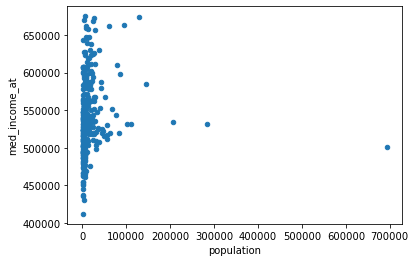

In [206]:
kommuneDF.loc[kommuneDF.year==2020,:].plot.scatter(x="population", y="med_income_at")

<AxesSubplot:ylabel='Frequency'>

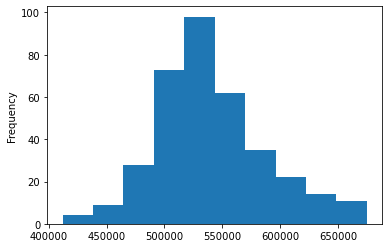

In [175]:
kommuneDF.loc[kommuneDF.year==2020,"med_income_at"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

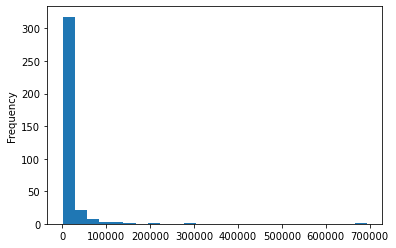

In [208]:
kommuneDF.loc[kommuneDF.year==2020,"population"].plot.hist(bins=25)